In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False


class NaiveBayesClassifier:
    def __init__(self, alpha=1.0):
        """
        初始化朴素贝叶斯分类器
        
        参数:
            alpha: 拉普拉斯平滑参数（默认为1.0）
        """
        self.alpha = alpha
        self.classes = None
        self.class_priors = {}
        self.feature_probs = {}
        self.continuous_features = []
        self.categorical_features = []
        self.feature_stats = {}  # 存储连续特征的均值和标准差
        
    def fit(self, X, y, continuous_cols=None):
        """
        训练朴素贝叶斯模型
        
        参数:
            X: 特征矩阵 (DataFrame)
            y: 标签向量
            continuous_cols: 连续型特征列名列表
        """
        self.classes = np.unique(y)
        n_samples = len(y)
        
        # 识别连续型和类别型特征
        if continuous_cols is None:
            continuous_cols = []
        self.continuous_features = continuous_cols
        self.categorical_features = [col for col in X.columns if col not in continuous_cols]
        
        # 计算类先验概率 P(Y=c)
        for c in self.classes:
            count = np.sum(y == c)
            self.class_priors[c] = (count + self.alpha) / (n_samples + self.alpha * len(self.classes))
        
        # 计算特征概率
        for c in self.classes:
            X_c = X[y == c]
            self.feature_probs[c] = {}
            self.feature_stats[c] = {}
            
            # 处理类别型特征：计算条件概率 P(X_i=x|Y=c)
            for feature in self.categorical_features:
                feature_values = X[feature].unique()
                n_values = len(feature_values)
                
                self.feature_probs[c][feature] = {}
                for value in feature_values:
                    count = np.sum(X_c[feature] == value)
                    # 拉普拉斯平滑
                    prob = (count + self.alpha) / (len(X_c) + self.alpha * n_values)
                    self.feature_probs[c][feature][value] = prob
            
            # 处理连续型特征：假设高斯分布
            for feature in self.continuous_features:
                mean = X_c[feature].mean()
                std = X_c[feature].std()
                if std == 0 or np.isnan(std):
                    std = 1e-6  # 避免除零
                self.feature_stats[c][feature] = {'mean': mean, 'std': std}
        
        return self
    
    def _gaussian_probability(self, x, mean, std):
        """
        计算高斯概率密度
        """
        exponent = np.exp(-((x - mean) ** 2) / (2 * std ** 2))
        return (1 / (np.sqrt(2 * np.pi) * std)) * exponent
    
    def predict_proba(self, X):
        """
        预测每个类别的概率
        
        返回:
            概率矩阵 (n_samples, n_classes)
        """
        n_samples = len(X)
        probs = np.zeros((n_samples, len(self.classes)))
        
        for idx, c in enumerate(self.classes):
            # 从类先验概率开始（使用对数概率避免下溢）
            log_prob = np.log(self.class_priors[c]) * np.ones(n_samples)
            
            # 类别型特征
            for feature in self.categorical_features:
                for i in range(n_samples):
                    value = X.iloc[i][feature]
                    if value in self.feature_probs[c][feature]:
                        log_prob[i] += np.log(self.feature_probs[c][feature][value])
                    else:
                        # 未见过的值，使用平滑概率
                        n_values = len(self.feature_probs[c][feature])
                        smoothed_prob = self.alpha / (n_samples + self.alpha * n_values)
                        log_prob[i] += np.log(max(smoothed_prob, 1e-10))
            
            # 连续型特征
            for feature in self.continuous_features:
                mean = self.feature_stats[c][feature]['mean']
                std = self.feature_stats[c][feature]['std']
                feature_probs = self._gaussian_probability(X[feature].values, mean, std)
                # 避免log(0)
                feature_probs = np.maximum(feature_probs, 1e-10)
                log_prob += np.log(feature_probs)
            
            probs[:, idx] = log_prob
        
        # 转换回概率（归一化）
        # 使用log-sum-exp技巧避免数值下溢
        probs = probs - np.max(probs, axis=1, keepdims=True)
        probs = np.exp(probs)
        probs = probs / np.sum(probs, axis=1, keepdims=True)
        
        return probs
    
    def predict(self, X):
        """
        预测类别标签
        """
        probs = self.predict_proba(X)
        return self.classes[np.argmax(probs, axis=1)]


def evaluate_model(y_true, y_pred, y_proba=None):
    """
    评估模型性能
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    print("\n" + "="*60)
    print("模型评估结果")
    print("="*60)
    
    # 计算评估指标
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"\nAccuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    
    # 混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n混淆矩阵:")
    print(cm)
    print(f"TN={cm[0,0]}, FP={cm[0,1]}, FN={cm[1,0]}, TP={cm[1,1]}")
    
    # 详细分类报告
    print(f"\n详细分类报告:")
    print(classification_report(y_true, y_pred, target_names=['<=50K', '>50K'], zero_division=0))
    
    # 可视化混淆矩阵
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 混淆矩阵
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['<=50K', '>50K'],
                yticklabels=['<=50K', '>50K'],
                cbar_kws={'label': '样本数量'},
                ax=axes[0])
    axes[0].set_xlabel('预测标签', fontsize=12)
    axes[0].set_ylabel('真实标签', fontsize=12)
    axes[0].set_title('混淆矩阵', fontsize=14, fontweight='bold')
    
    # 在每个格子中添加百分比
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            axes[0].text(j+0.5, i+0.7, f'({cm[i,j]/total*100:.1f}%)', 
                        ha='center', va='center', fontsize=10, color='red')
    
    # 如果有概率，绘制ROC曲线
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        
        axes[1].plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC curve (AUC = {roc_auc:.4f})')
        axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('False Positive Rate', fontsize=12)
        axes[1].set_ylabel('True Positive Rate', fontsize=12)
        axes[1].set_title(f'ROC Curve (AUC = {roc_auc:.4f})', fontsize=14, fontweight='bold')
        axes[1].legend(loc="lower right")
        axes[1].grid(alpha=0.3)
        
        print(f"\nAUC Score: {roc_auc:.4f}")
    
    plt.tight_layout()
    plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
    print("\n评估结果图已保存到: model_evaluation.png")
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


def visualize_results(results_dict):
    """
    可视化不同参数下的结果
    """
    alphas = list(results_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for idx, metric in enumerate(metrics):
        values = [results_dict[alpha][metric] for alpha in alphas]
        axes[idx].plot(alphas, values, marker='o', linewidth=2, markersize=8, 
                      color=colors[idx], label=metric.capitalize())
        axes[idx].set_xlabel('Alpha (平滑参数)', fontsize=11)
        axes[idx].set_ylabel(metric.capitalize(), fontsize=11)
        axes[idx].set_title(f'{metric.capitalize()} vs Alpha', fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_xscale('log')
        axes[idx].legend()
        
        # 标注最佳值
        best_idx = np.argmax(values)
        axes[idx].scatter([alphas[best_idx]], [values[best_idx]], 
                         color='red', s=100, zorder=5)
        axes[idx].annotate(f'Best: {values[best_idx]:.4f}', 
                          xy=(alphas[best_idx], values[best_idx]),
                          xytext=(10, 10), textcoords='offset points',
                          bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.tight_layout()
    plt.savefig('alpha_comparison.png', dpi=300, bbox_inches='tight')
    print("\n参数对比图已保存到: alpha_comparison.png")
    plt.show()


def explore_alpha_values(X_train, X_test, y_train, y_test, continuous_cols, 
                        alpha_values=[0.1, 0.5, 1.0, 2.0, 5.0, 10.0]):
    """
    探索不同平滑参数对结果的影响
    """
    print("\n" + "="*60)
    print("探索不同平滑参数 (Alpha) 的影响")
    print("="*60)
    
    results = {}
    
    for alpha in alpha_values:
        print(f"\n{'='*40}")
        print(f"Alpha = {alpha}")
        print(f"{'='*40}")
        
        # 训练模型
        nb = NaiveBayesClassifier(alpha=alpha)
        nb.fit(X_train, y_train, continuous_cols=continuous_cols)
        
        # 预测
        y_pred = nb.predict(X_test)
        
        # 评估（不显示详细信息）
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0)
        }
        
        print(f"Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, "
              f"Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")
        
        results[alpha] = metrics
    
    # 可视化对比
    visualize_results(results)
    
    # 打印汇总表
    print("\n" + "="*60)
    print("Alpha参数对比汇总")
    print("="*60)
    df_results = pd.DataFrame(results).T
    df_results.index.name = 'Alpha'
    print(df_results.to_string())
    df_results.to_csv('alpha_comparison_results.csv')
    print("\n对比结果已保存到: alpha_comparison_results.csv")
    
    return results


In [11]:
def load_and_preprocess_data(train_file, test_file):
    """
    加载和预处理数据（无列名的CSV）
    """
    
    # 定义列名（UCI Adult数据集标准列名）
    column_names = [
        '年纪', '工作性质', '家庭收入', '学位', '工位类型',
        '婚姻状况', '族裔', '性别', '工作地点', '国籍',
         '收入'
    ]
    
    try:
        # 读取数据（没有header）
        train_df = pd.read_csv(train_file, header=None, names=column_names, skipinitialspace=True)
        test_df = pd.read_csv(test_file, header=None, names=column_names, skipinitialspace=True)
    except FileNotFoundError as e:
        print(f"错误: 找不到文件 - {e}")
        return None, None, None, None, None, None
    
    print(f"\n训练集大小: {train_df.shape}")
    print(f"测试集大小: {test_df.shape}")
    
    # 显示列名和前几行
    print(f"\n列名: {train_df.columns.tolist()}")
    print(f"\n训练集前5行:")
    print(train_df.head())
    
    # 去除所有字符串列的前后空格
    for col in train_df.columns:
        if train_df[col].dtype == 'object':
            train_df[col] = train_df[col].str.strip()
            test_df[col] = test_df[col].str.strip()
    
    # 分离特征和标签
    X_train = train_df.iloc[:, :-1].copy()
    y_train = train_df.iloc[:, -1].copy()
    X_test = test_df.iloc[:, :-1].copy()
    y_test = test_df.iloc[:, -1].copy()
    
    # 处理标签
    print(f"\n原始标签唯一值: {y_train.unique()}")

    y_train = y_train.astype(str).str.strip().str.replace('.', '', regex=False)
    y_test = y_test.astype(str).str.strip().str.replace('.', '', regex=False)

    y_train = (y_train == '>50K').astype(int)
    y_test = (y_test == '>50K').astype(int)
    
    print(f"标签分布 - 训练集: <=50K={np.sum(y_train==0)}, >50K={np.sum(y_train==1)}")
    print(f"标签分布 - 测试集: <=50K={np.sum(y_test==0)}, >50K={np.sum(y_test==1)}")
    
    # 识别连续型特征（数值型列）
    continuous_cols = []
    for col in X_train.columns:
        if X_train[col].dtype in ['int64', 'float64']:
            continuous_cols.append(col)
    
    print(f"\n识别的连续型特征: {continuous_cols}")
    
    # 对类别型特征进行编码
    categorical_cols = [col for col in X_train.columns if col not in continuous_cols]
    print(f"识别的类别型特征: {categorical_cols}")
    
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        # 确保是字符串类型
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)
        
        # 合并训练集和测试集的唯一值
        all_values = pd.concat([X_train[col], X_test[col]]).unique()
        le.fit(all_values)
        
        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
        label_encoders[col] = le
        
        print(f"  {col}: {len(all_values)} 个唯一值")
    
    return X_train, X_test, y_train, y_test, continuous_cols, label_encoders

In [12]:
# 加载和预处理数据
train_file = 'Bayesian_Dataset_train.csv'
test_file = 'Bayesian_Dataset_test.csv'

data = load_and_preprocess_data(train_file, test_file)

if data[0] is None:
    print("数据加载失败，程序退出")
    exit(1)

X_train, X_test, y_train, y_test, continuous_cols, label_encoders = data



训练集大小: (27202, 11)
测试集大小: (2960, 11)

列名: ['年纪', '工作性质', '家庭收入', '学位', '工位类型', '婚姻状况', '族裔', '性别', '工作地点', '国籍', '收入']

训练集前5行:
   年纪              工作性质    家庭收入         学位                工位类型  \
0  39         State-gov   77516  Bachelors       Never-married   
1  50  Self-emp-not-inc   83311  Bachelors  Married-civ-spouse   
2  38           Private  215646    HS-grad            Divorced   
3  53           Private  234721       11th  Married-civ-spouse   
4  28           Private  338409  Bachelors  Married-civ-spouse   

                婚姻状况             族裔     性别    工作地点             国籍     收入  
0       Adm-clerical  Not-in-family  White    Male  United-States  <=50K  
1    Exec-managerial        Husband  White    Male  United-States  <=50K  
2  Handlers-cleaners  Not-in-family  White    Male  United-States  <=50K  
3  Handlers-cleaners        Husband  Black    Male  United-States  <=50K  
4     Prof-specialty           Wife  Black  Female           Cuba  <=50K  

原始标签唯一值: ['<=50K' '>50K

In [16]:
# 训练朴素贝叶斯模型（默认 alpha=1.0）

nb_classifier = NaiveBayesClassifier(alpha=1.0)
nb_classifier.fit(X_train, y_train, continuous_cols=continuous_cols)


进行预测...

模型评估结果

Accuracy:  0.8003
Precision: 0.5808
Recall:    0.7540
F1 Score:  0.6562

混淆矩阵:
[[1805  407]
 [ 184  564]]
TN=1805, FP=407, FN=184, TP=564

详细分类报告:
              precision    recall  f1-score   support

       <=50K       0.91      0.82      0.86      2212
        >50K       0.58      0.75      0.66       748

    accuracy                           0.80      2960
   macro avg       0.74      0.79      0.76      2960
weighted avg       0.82      0.80      0.81      2960


AUC Score: 0.8725

评估结果图已保存到: model_evaluation.png


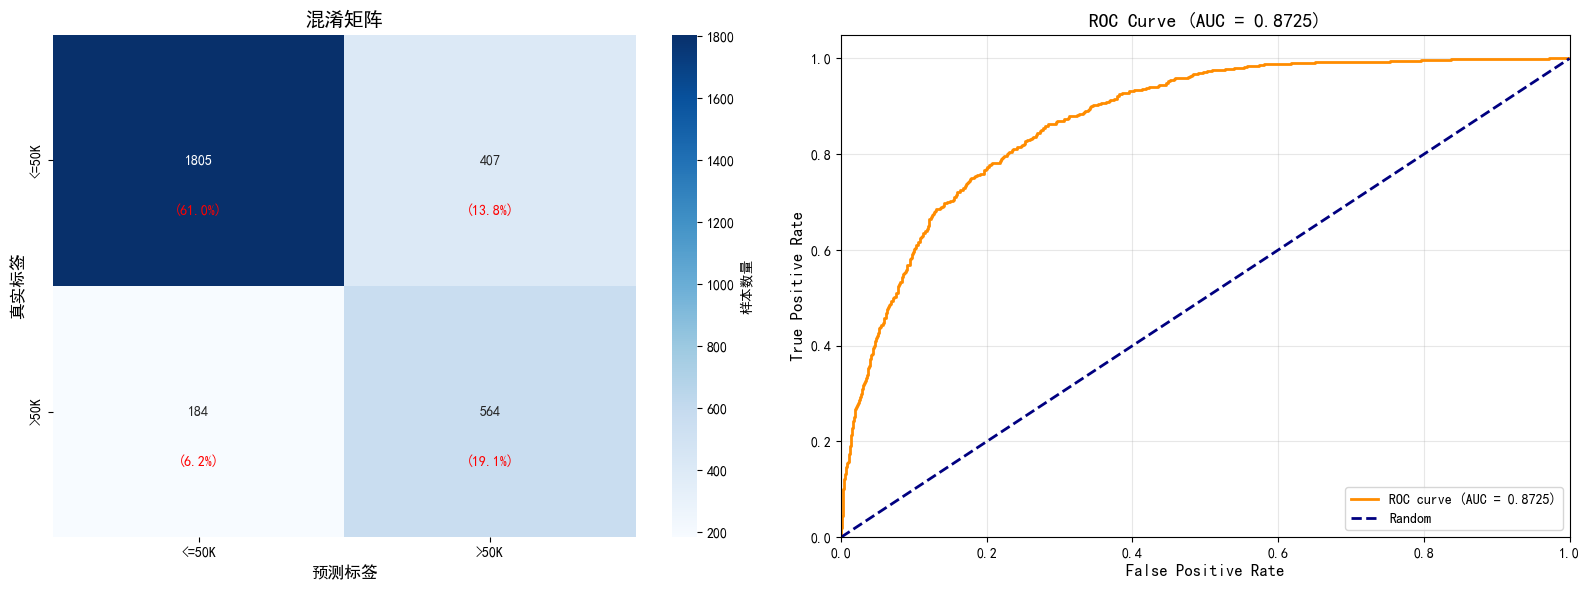

In [17]:
print("\n进行预测...")
y_pred = nb_classifier.predict(X_test)
y_proba = nb_classifier.predict_proba(X_test)

metrics = evaluate_model(y_test, y_pred, y_proba)

In [19]:
# 基本预测结果
results_df = pd.DataFrame({
    'Predicted_Income': ['<=50K' if p == 0 else '>50K' for p in y_pred]
})
results_df.to_csv('bayesian_predictions.csv', index=False)

# 详细结果（包含概率）
detailed_results = pd.DataFrame({
    'True_Label': ['<=50K' if p == 0 else '>50K' for p in y_test.values],
    'Predicted_Label': ['<=50K' if p == 0 else '>50K' for p in y_pred],
    'Probability_<=50K': y_proba[:, 0],
    'Probability_>50K': y_proba[:, 1],
    'Correct': (y_test.values == y_pred).astype(int)
})
detailed_results.to_csv('bayesian_detailed_results.csv', index=False)



探索不同平滑参数 (Alpha) 的影响

Alpha = 0.01
Accuracy: 0.8010, Precision: 0.5820, Recall: 0.7540, F1: 0.6570

Alpha = 0.1
Accuracy: 0.8010, Precision: 0.5820, Recall: 0.7540, F1: 0.6570

Alpha = 0.5
Accuracy: 0.8010, Precision: 0.5820, Recall: 0.7540, F1: 0.6570

Alpha = 1.0
Accuracy: 0.8003, Precision: 0.5808, Recall: 0.7540, F1: 0.6562

Alpha = 2.0
Accuracy: 0.7993, Precision: 0.5792, Recall: 0.7527, F1: 0.6547

Alpha = 5.0
Accuracy: 0.7980, Precision: 0.5772, Recall: 0.7500, F1: 0.6523

Alpha = 10.0
Accuracy: 0.7970, Precision: 0.5754, Recall: 0.7500, F1: 0.6512

Alpha = 20.0
Accuracy: 0.7956, Precision: 0.5735, Recall: 0.7460, F1: 0.6485


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 


参数对比图已保存到: alpha_comparison.png


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


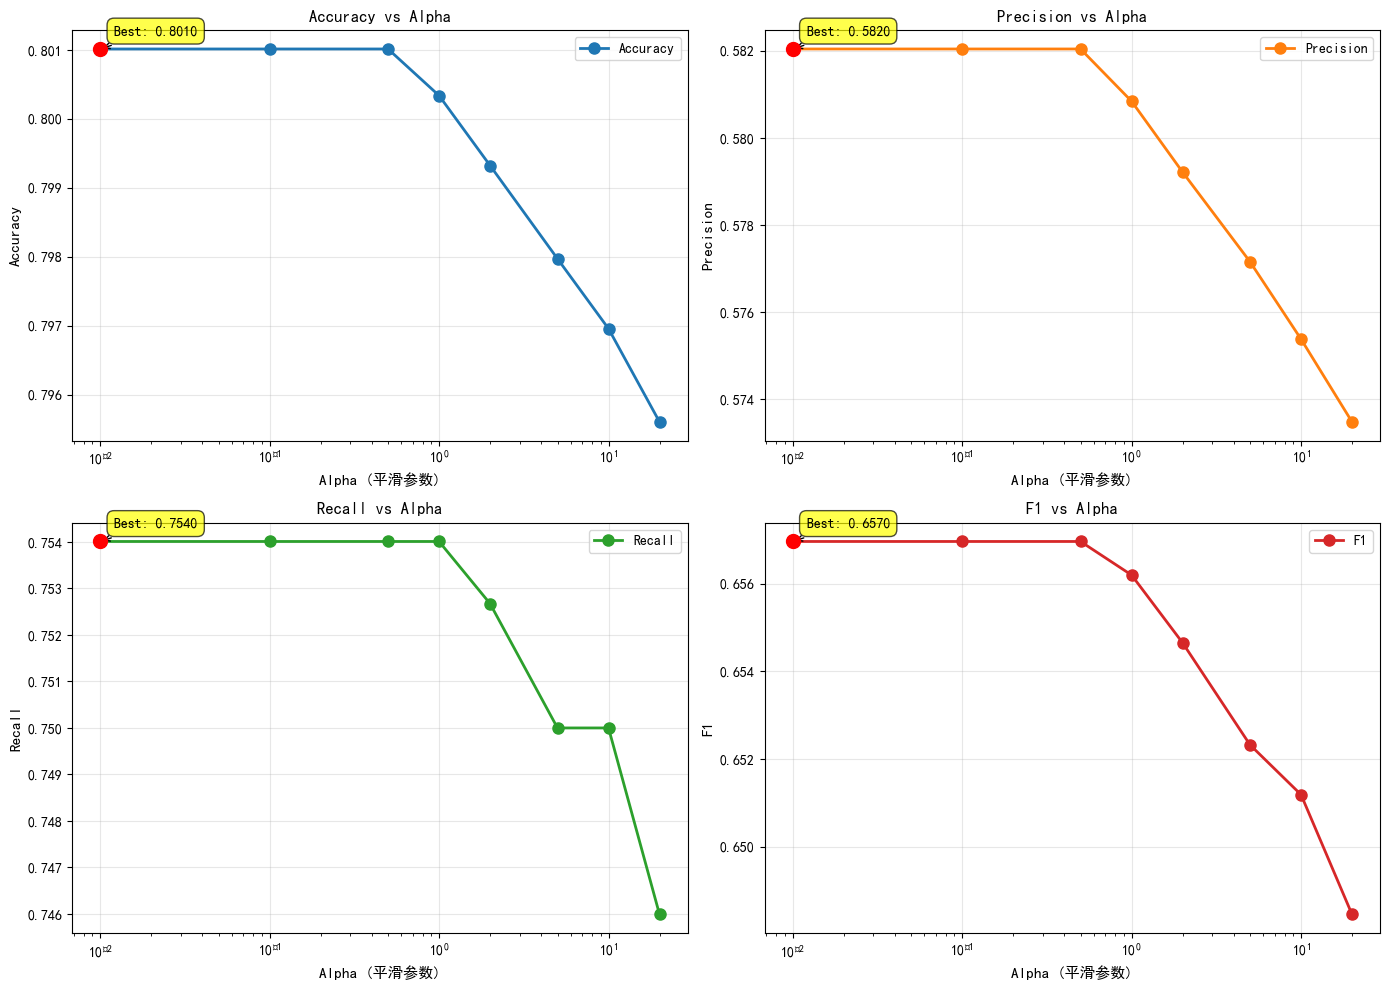


Alpha参数对比汇总
       accuracy  precision    recall        f1
Alpha                                         
0.01   0.801014   0.582043  0.754011  0.656960
0.10   0.801014   0.582043  0.754011  0.656960
0.50   0.801014   0.582043  0.754011  0.656960
1.00   0.800338   0.580844  0.754011  0.656195
2.00   0.799324   0.579218  0.752674  0.654651
5.00   0.797973   0.577160  0.750000  0.652326
10.00  0.796959   0.575385  0.750000  0.651190
20.00  0.795608   0.573484  0.745989  0.648460

对比结果已保存到: alpha_comparison_results.csv

最终总结

最佳 Alpha (基于F1分数): 0.01

最佳模型性能指标:
  Accuracy    : 0.8010
  Precision   : 0.5820
  Recall      : 0.7540
  F1          : 0.6570


In [20]:
# 探索不同平滑参数的影响
alpha_results = explore_alpha_values(
    X_train, X_test, y_train, y_test, continuous_cols,
    alpha_values=[0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
)

# 找出最佳 alpha
best_alpha = max(alpha_results.items(), key=lambda x: x[1]['f1'])[0]

print("\n" + "="*60)
print("最终总结")
print("="*60)
print(f"\n最佳 Alpha (基于F1分数): {best_alpha}")
print(f"\n最佳模型性能指标:")
for metric, value in alpha_results[best_alpha].items():
    print(f"  {metric.capitalize():12s}: {value:.4f}")

In [ ]:
print("\n" + "="*60)
print("生成的文件清单")
print("="*60)
print("✓ bayesian_predictions.csv - 预测标签")
print("✓ bayesian_detailed_results.csv - 详细结果（含概率）")
print("✓ model_evaluation.png - 混淆矩阵和ROC曲线")
print("✓ alpha_comparison.png - 不同Alpha参数的对比")
print("✓ alpha_comparison_results.csv - Alpha参数对比数据")
print("="*60)